# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

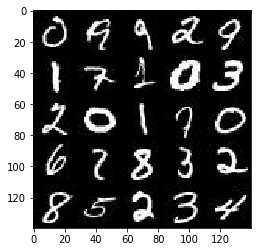

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

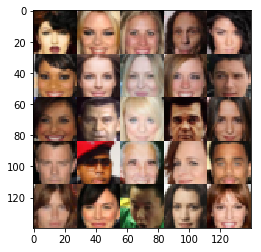

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [14]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')    
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 32x32x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 16x16x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 8x8x256

        # Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x128 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Train
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    class GAN:
        def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
            image_width = data_shape[1]
            image_height = data_shape[2]
            image_channels = data_shape[3]
            self.input_real, self.input_z, self.learning_rate = model_inputs(image_width, image_height,
                                                                             image_channels, z_size)
            
            self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[3])
            
            self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

    net = GAN(data_shape, z_dim, learning_rate, alpha=0.2, beta1=beta1)
    
    losses = []
    samples = []
    batches = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batches += 1
                
                # Sample random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z})
                
                if batches % print_every == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses
                    losses.append((train_loss_d, train_loss_g))

                if batches % show_every == 0:
                    gen_samples = sess.run(generator(net.input_z, data_shape[3], is_train=False),
                                   feed_dict={net.input_z: batch_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 16, net.input_z, data_shape[3], data_image_mode)
                    plt.show()

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6776... Generator Loss: 1.0909
Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 0.9454
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 0.9410
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 1.0029
Epoch 1/2... Discriminator Loss: 1.1573... Generator Loss: 0.8332
Epoch 1/2... Discriminator Loss: 1.1886... Generator Loss: 0.5429
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 0.7121... Generator Loss: 1.3868
Epoch 1/2... Discriminator Loss: 0.8233... Generator Loss: 0.9108


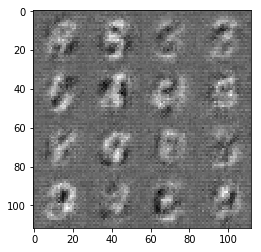

Epoch 1/2... Discriminator Loss: 0.8684... Generator Loss: 0.7091
Epoch 1/2... Discriminator Loss: 0.5316... Generator Loss: 1.7106
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 0.5298
Epoch 1/2... Discriminator Loss: 0.5394... Generator Loss: 1.0943
Epoch 1/2... Discriminator Loss: 0.5631... Generator Loss: 2.2589
Epoch 1/2... Discriminator Loss: 0.4035... Generator Loss: 1.5906
Epoch 1/2... Discriminator Loss: 0.3239... Generator Loss: 1.7161
Epoch 1/2... Discriminator Loss: 0.3588... Generator Loss: 3.4273
Epoch 1/2... Discriminator Loss: 0.5072... Generator Loss: 1.3383
Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 0.6380


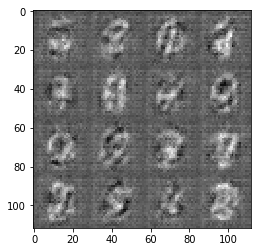

Epoch 1/2... Discriminator Loss: 0.3630... Generator Loss: 1.8937
Epoch 1/2... Discriminator Loss: 0.2056... Generator Loss: 2.4357
Epoch 1/2... Discriminator Loss: 0.6926... Generator Loss: 0.8873
Epoch 2/2... Discriminator Loss: 0.3313... Generator Loss: 2.2253
Epoch 2/2... Discriminator Loss: 0.3535... Generator Loss: 2.9483
Epoch 2/2... Discriminator Loss: 0.3389... Generator Loss: 1.9928
Epoch 2/2... Discriminator Loss: 0.3175... Generator Loss: 1.8318
Epoch 2/2... Discriminator Loss: 0.5145... Generator Loss: 3.0777
Epoch 2/2... Discriminator Loss: 0.2616... Generator Loss: 2.1533
Epoch 2/2... Discriminator Loss: 0.2691... Generator Loss: 2.9204


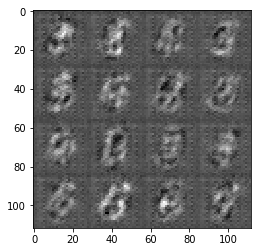

Epoch 2/2... Discriminator Loss: 1.4537... Generator Loss: 0.3138
Epoch 2/2... Discriminator Loss: 0.2150... Generator Loss: 2.4271
Epoch 2/2... Discriminator Loss: 0.3692... Generator Loss: 1.5839
Epoch 2/2... Discriminator Loss: 0.3459... Generator Loss: 1.6166
Epoch 2/2... Discriminator Loss: 0.3241... Generator Loss: 3.2403
Epoch 2/2... Discriminator Loss: 0.3990... Generator Loss: 1.3691
Epoch 2/2... Discriminator Loss: 0.4075... Generator Loss: 2.7344
Epoch 2/2... Discriminator Loss: 0.2811... Generator Loss: 2.0966
Epoch 2/2... Discriminator Loss: 0.3301... Generator Loss: 1.6720
Epoch 2/2... Discriminator Loss: 0.3388... Generator Loss: 1.8865


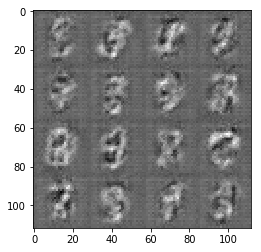

Epoch 2/2... Discriminator Loss: 0.4213... Generator Loss: 1.3906
Epoch 2/2... Discriminator Loss: 0.2496... Generator Loss: 2.3801
Epoch 2/2... Discriminator Loss: 0.1764... Generator Loss: 2.5748
Epoch 2/2... Discriminator Loss: 0.4196... Generator Loss: 3.8059
Epoch 2/2... Discriminator Loss: 0.2602... Generator Loss: 2.7762
Epoch 2/2... Discriminator Loss: 0.2133... Generator Loss: 2.4136


In [21]:
batch_size = 256
z_dim = 100
learning_rate = .0001
beta1 = .5
print_every = 10
show_every = 100

import matplotlib.pyplot as plt
import pickle as pkl

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.1361
Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 2.0665
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.2542
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 2.4799


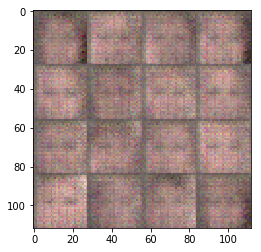

Epoch 1/1... Discriminator Loss: 0.6305... Generator Loss: 1.5792
Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 1.5306
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 1.6729
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 1.7001
Epoch 1/1... Discriminator Loss: 0.2712... Generator Loss: 3.0586
Epoch 1/1... Discriminator Loss: 1.6640... Generator Loss: 0.2769
Epoch 1/1... Discriminator Loss: 0.6545... Generator Loss: 2.8820
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 2.7989
Epoch 1/1... Discriminator Loss: 1.7344... Generator Loss: 0.2687
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 1.7464


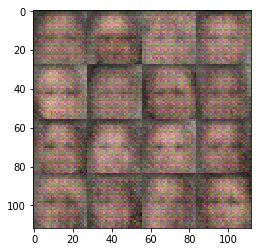

Epoch 1/1... Discriminator Loss: 1.7039... Generator Loss: 0.3006
Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 2.9829
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 2.3407... Generator Loss: 0.1243
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.8611


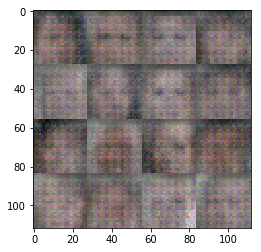

Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 1.1895
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 1.1053


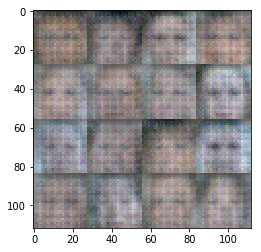

Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 3.2525
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 0.1904... Generator Loss: 4.4990
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 1.1390


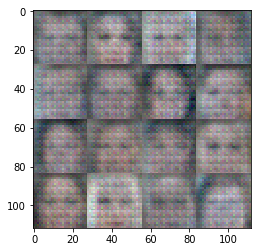

Epoch 1/1... Discriminator Loss: 0.2209... Generator Loss: 2.7099
Epoch 1/1... Discriminator Loss: 0.2644... Generator Loss: 3.8381
Epoch 1/1... Discriminator Loss: 0.1014... Generator Loss: 5.9841
Epoch 1/1... Discriminator Loss: 0.7196... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 0.2228... Generator Loss: 5.5127
Epoch 1/1... Discriminator Loss: 0.0937... Generator Loss: 3.6657
Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 6.2551
Epoch 1/1... Discriminator Loss: 0.4420... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 1.9106
Epoch 1/1... Discriminator Loss: 0.0461... Generator Loss: 4.1869


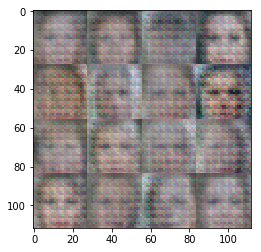

Epoch 1/1... Discriminator Loss: 0.0779... Generator Loss: 10.4606
Epoch 1/1... Discriminator Loss: 0.5542... Generator Loss: 1.5924
Epoch 1/1... Discriminator Loss: 2.5214... Generator Loss: 0.1085
Epoch 1/1... Discriminator Loss: 0.0727... Generator Loss: 11.2336
Epoch 1/1... Discriminator Loss: 0.1776... Generator Loss: 5.7705
Epoch 1/1... Discriminator Loss: 2.2747... Generator Loss: 0.1324
Epoch 1/1... Discriminator Loss: 0.0436... Generator Loss: 9.4909
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.4399
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 8.5162
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 0.9205


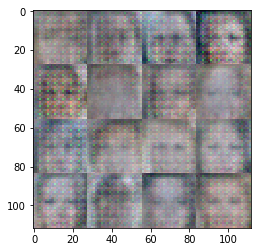

Epoch 1/1... Discriminator Loss: 0.1890... Generator Loss: 2.3336
Epoch 1/1... Discriminator Loss: 0.4217... Generator Loss: 7.9669
Epoch 1/1... Discriminator Loss: 0.0417... Generator Loss: 5.8859
Epoch 1/1... Discriminator Loss: 0.1410... Generator Loss: 2.8919
Epoch 1/1... Discriminator Loss: 0.0623... Generator Loss: 6.7563
Epoch 1/1... Discriminator Loss: 1.7341... Generator Loss: 3.0926
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 7.6584
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 7.8285
Epoch 1/1... Discriminator Loss: 0.4066... Generator Loss: 2.3438


In [22]:
batch_size = 256
z_dim = 100
learning_rate = .0001
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.